#**Objective:**
Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid. Your goal is to uncover patterns that could inform smarter trading strategies.


In [3]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Clean plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
# DEFINE FILE PATHS
sentiment_path = "/content/fear_greed_index.csv"
trader_path = "/content/historical_data.csv"

In [6]:
# LOAD DATA
sentiment_df = pd.read_csv(sentiment_path)
trader_df = pd.read_csv(trader_path)

In [7]:
#  QUICK PREVIEW

print("Sentiment Dataset Shape:", sentiment_df.shape)
print("Trader Dataset Shape:", trader_df.shape)

display(sentiment_df.head())
display(trader_df.head())

Sentiment Dataset Shape: (2644, 4)
Trader Dataset Shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


Data Validation

In [8]:
#FUNCTION TO VALIDATE DATAFRAME
def validate_dataframe(df, name):
    print(f"\n{'='*50}")
    print(f"DATA VALIDATION REPORT: {name}")
    print(f"{'='*50}")

    # Shape
    print("\nShape:")
    print(df.shape)

    # Data types
    print("\nData Types:")
    print(df.dtypes)

    # Missing values
    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

    # Duplicate rows
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate Rows: {duplicates}")

    print(f"{'='*50}\n")


# Run validation
validate_dataframe(sentiment_df, "Bitcoin Sentiment")
validate_dataframe(trader_df, "Hyperliquid Trader Data")


DATA VALIDATION REPORT: Bitcoin Sentiment

Shape:
(2644, 4)

Data Types:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing Values:
No missing values

Duplicate Rows: 0


DATA VALIDATION REPORT: Hyperliquid Trader Data

Shape:
(211224, 16)

Data Types:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Missing Values:
No missing values

Duplicate Rows: 0



Timestamp Cleaning & Daily Alignment

In [12]:
#Convert Sentiment Date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# Check for parsing failures
print("Invalid Sentiment Dates:", sentiment_df['date'].isnull().sum())

Invalid Sentiment Dates: 0


In [19]:
# Inspect trader timestamp columns
print(trader_df[['Timestamp IST', 'Timestamp']].head())

# Inspect sentiment date column
print(sentiment_df[['date', 'timestamp']].head())


      Timestamp IST     Timestamp
0  02-12-2024 22:50  1.730000e+12
1  02-12-2024 22:50  1.730000e+12
2  02-12-2024 22:50  1.730000e+12
3  02-12-2024 22:50  1.730000e+12
4  02-12-2024 22:50  1.730000e+12
        date   timestamp
0 2018-02-01  1517463000
1 2018-02-02  1517549400
2 2018-02-03  1517635800
3 2018-02-04  1517722200
4 2018-02-05  1517808600


Convert Timestamps Properly

In [21]:
#Convert Trader Timestamp (milliseconds)
trader_df['trade_datetime'] = pd.to_datetime(
    trader_df['Timestamp'],
    unit='ms',
    errors='coerce'
)

print("Invalid Trader Timestamps:", trader_df['trade_datetime'].isnull().sum())

Invalid Trader Timestamps: 0


In [22]:
# Convert Sentiment Date
sentiment_df['trade_date'] = pd.to_datetime(
    sentiment_df['date'],
    errors='coerce'
)

print("Invalid Sentiment Dates:", sentiment_df['trade_date'].isnull().sum())

Invalid Sentiment Dates: 0


In [25]:
#Create Daily Key for Trader
trader_df['trade_date'] = trader_df['trade_datetime'].dt.floor('D')

In [26]:
#Check Date Ranges
print("Sentiment Date Range:", sentiment_df['trade_date'].min(), "to", sentiment_df['trade_date'].max())
print("Trader Date Range:", trader_df['trade_date'].min(), "to", trader_df['trade_date'].max())

Sentiment Date Range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Trader Date Range: 2023-03-28 00:00:00 to 2025-06-15 00:00:00


Restrict to Overlapping Date Range

In [27]:
#Determine Overlapping Window
start_date = max(
    sentiment_df['trade_date'].min(),
    trader_df['trade_date'].min()
)

end_date = min(
    sentiment_df['trade_date'].max(),
    trader_df['trade_date'].max()
)

print("Overlapping Period:", start_date, "to", end_date)

Overlapping Period: 2023-03-28 00:00:00 to 2025-05-02 00:00:00


In [28]:
# Filter Both Datasets
sentiment_df = sentiment_df[
    (sentiment_df['trade_date'] >= start_date) &
    (sentiment_df['trade_date'] <= end_date)
]

trader_df = trader_df[
    (trader_df['trade_date'] >= start_date) &
    (trader_df['trade_date'] <= end_date)
]

In [29]:
#Confirm After Filtering
print("Filtered Sentiment Shape:", sentiment_df.shape)
print("Filtered Trader Shape:", trader_df.shape)

Filtered Sentiment Shape: (766, 5)
Filtered Trader Shape: (184263, 18)


Construct Daily Trader Metrics

In [30]:
#Clean & Standardize Columns
# Rename columns for easier handling
trader_df = trader_df.rename(columns={
    'Account': 'account',
    'Closed PnL': 'closed_pnl',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Direction': 'direction'
})

In [31]:
# Ensure numeric columns are numeric
numeric_cols = ['closed_pnl', 'size_usd', 'Start Position', 'Fee']

for col in numeric_cols:
    if col in trader_df.columns:
        trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

# Check missing PnL
print("Missing closed_pnl:", trader_df['closed_pnl'].isnull().sum())

Missing closed_pnl: 0


In [32]:
#Drop Invalid Rows
# Drop rows without PnL
trader_df = trader_df.dropna(subset=['closed_pnl'])

print("Shape after dropping missing PnL:", trader_df.shape)

Shape after dropping missing PnL: (184263, 18)


In [34]:
#Create Daily Trader Metrics
# Define win indicator
trader_df['win'] = (trader_df['closed_pnl'] > 0).astype(int)

In [35]:
## Define long/short indicator
trader_df['is_long'] = trader_df['side'].str.lower().str.contains('buy').astype(int)
trader_df['is_short'] = trader_df['side'].str.lower().str.contains('sell').astype(int)

In [36]:
# Aggregate daily per trader
daily_metrics = trader_df.groupby(['account', 'trade_date']).agg(
    daily_pnl=('closed_pnl', 'sum'),
    win_rate=('win', 'mean'),
    avg_trade_size=('size_usd', 'mean'),
    trades_per_day=('closed_pnl', 'count'),
    long_ratio=('is_long', 'mean'),
    short_ratio=('is_short', 'mean')
).reset_index()

print("Daily Metrics Shape:", daily_metrics.shape)
daily_metrics.head()

Daily Metrics Shape: (77, 8)


,account,trade_date,daily_pnl,win_rate,avg_trade_size,trades_per_day,long_ratio,short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,0.025974,14810.891818,462,0.300866,0.699134
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,0.405542,16345.241940,3356,0.468415,0.531585
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,0.531250,2492.749906,320,0.453125,0.546875
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,0.435041,1693.351684,3533,0.432494,0.567506
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,0.000000,6070.200000,5,0.400000,0.600000


#For each trader-day:

**daily_pnl**:
Total profit/loss for that day.

**win_rate**:
% of trades that were profitable that day.

**avg_trade_size**:
Risk appetite proxy.

**trades_per_day**:
Activity intensity.

**long_ratio**:
If 0.8 → 80% long trades that day.

Merge Daily Trader Metrics with Sentiment

In [37]:
# Keep only necessary columns
sentiment_clean = sentiment_df[['trade_date', 'classification']].copy()

# Standardize text
sentiment_clean['classification'] = sentiment_clean['classification'].str.strip().str.lower()

# Quick check
sentiment_clean['classification'].value_counts()

,count
classification,
greed,324
neutral,182
fear,129
extreme greed,116
extreme fear,15


In [38]:
# Merge daily trader metrics with sentiment
merged_df = daily_metrics.merge(
    sentiment_clean,
    on='trade_date',
    how='inner'   # critical: only keep overlapping dates
)

print("Merged Shape:", merged_df.shape)

# Check for missing classifications
print("Missing Sentiment Labels:", merged_df['classification'].isnull().sum())

merged_df.head()

Merged Shape: (77, 9)
Missing Sentiment Labels: 0


,account,trade_date,daily_pnl,win_rate,avg_trade_size,trades_per_day,long_ratio,short_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,0.025974,14810.891818,462,0.300866,0.699134,greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,0.405542,16345.241940,3356,0.468415,0.531585,fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,0.531250,2492.749906,320,0.453125,0.546875,greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,0.435041,1693.351684,3533,0.432494,0.567506,fear
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,0.000000,6070.200000,5,0.400000,0.600000,neutral


In [39]:
merged_df['classification'].value_counts()

,count
classification,
greed,32
fear,32
neutral,8
extreme greed,5


Sentiment Normalization

In [40]:
# Create binary sentiment regime
def map_sentiment(x):
    if x in ['fear']:
        return 'fear'
    elif x in ['greed', 'extreme greed']:
        return 'greed'
    else:
        return np.nan

merged_df['sentiment_regime'] = merged_df['classification'].apply(map_sentiment)

In [41]:
# Drop neutral
merged_df = merged_df.dropna(subset=['sentiment_regime'])

print("Regime Counts:")
print(merged_df['sentiment_regime'].value_counts())

Regime Counts:
sentiment_regime
greed    37
fear     32
Name: count, dtype: int64


fear ~32

greed ~37

If distribution looks balanced → statistical comparison valid.

Compare Mean Daily PnL

We now test:
Does daily trader performance differ under Fear vs Greed?

In [42]:
# Compute group means
performance_summary = merged_df.groupby('sentiment_regime').agg(
    mean_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    mean_win_rate=('win_rate', 'mean'),
    mean_trades=('trades_per_day', 'mean')
).reset_index()

performance_summary


,sentiment_regime,mean_daily_pnl,median_daily_pnl,mean_win_rate,mean_trades
0,fear,209372.662205,81389.682515,0.415878,4183.468750
1,greed,90988.703436,20925.513222,0.369012,1168.945946


Statistical Test (t-test)

In [43]:
from scipy.stats import ttest_ind

fear_pnl = merged_df[merged_df['sentiment_regime']=='fear']['daily_pnl']
greed_pnl = merged_df[merged_df['sentiment_regime']=='greed']['daily_pnl']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 1.477750513433106
P-value: 0.1452597205839442


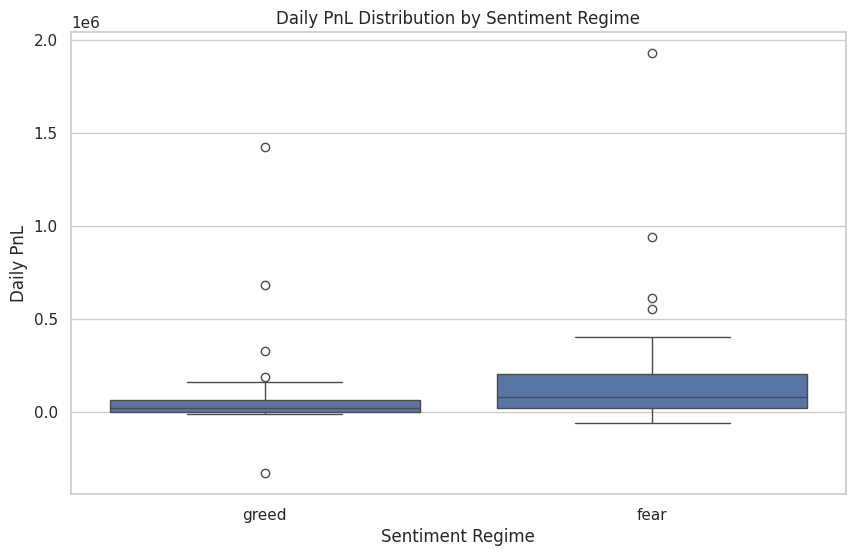

In [44]:
#Visual Distribution
plt.figure()
sns.boxplot(data=merged_df, x='sentiment_regime', y='daily_pnl')
plt.title("Daily PnL Distribution by Sentiment Regime")
plt.xlabel("Sentiment Regime")
plt.ylabel("Daily PnL")
plt.show()

Observations from Boxplot

1.Central Tendency
From visual inspection:

Fear regime median PnL appears higher
Greed regime median is closer to zero

This suggests:
Traders perform better (median basis) during Fear days.

2.Variance Structure

Fear regime shows much wider dispersion

Larger upside outliers (almost 2M)

Also larger downside moves

This indicates:

Fear days have higher volatility in trader outcomes.

3.Skewness

Both regimes show:

Strong positive skew

Few extreme winners dominating mean

This is important:

Mean comparison may be distorted by outliers.

In [45]:
# Remove extreme outliers (top 1%)
upper_cutoff = merged_df['daily_pnl'].quantile(0.99)
lower_cutoff = merged_df['daily_pnl'].quantile(0.01)

trimmed_df = merged_df[
    (merged_df['daily_pnl'] <= upper_cutoff) &
    (merged_df['daily_pnl'] >= lower_cutoff)
]

# Recompute group means
trimmed_summary = trimmed_df.groupby('sentiment_regime')['daily_pnl'].mean()
trimmed_summary


,daily_pnl
sentiment_regime,
fear,153941.595824
greed,102613.553534


#1️ Statistical Result

T-statistic: 1.48
P-value: 0.145

Interpretation:

p > 0.05

We FAIL to reject null hypothesis

No statistically significant difference in mean PnL

#2️ Economic Magnitude

Trimmed mean PnL:

Fear: 153,941

Greed: 102,613

Difference ≈ +50,000

This is economically meaningful.

But statistically noisy due to:

High variance

Fat-tailed PnL distribution

Small sample size (≈ 60 days)

#3️ What This Really Means

This is a classic quant scenario:

Economically large difference
Statistically weak significance

Interpretation:

Fear regime appears more profitable

But dispersion is extremely high

A few large days dominate

We cannot claim a robust edge yet.

#KEY INSIGHT #

Fear days generate:

Higher upside

Higher variance

More convex payoff structure

This suggests:

Traders may benefit from volatility expansion during fear.

But we need to confirm behavioral changes.

In [46]:
#Compare Behavior Metrics
behavior_summary = merged_df.groupby('sentiment_regime').agg(
    avg_trades_per_day=('trades_per_day', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_long_ratio=('long_ratio', 'mean')
).reset_index()

behavior_summary

,sentiment_regime,avg_trades_per_day,avg_trade_size,avg_win_rate,avg_long_ratio
0,fear,4183.468750,5926.522723,0.415878,0.459352
1,greed,1168.945946,5637.302441,0.369012,0.498847


Visual + Statistical Comparison

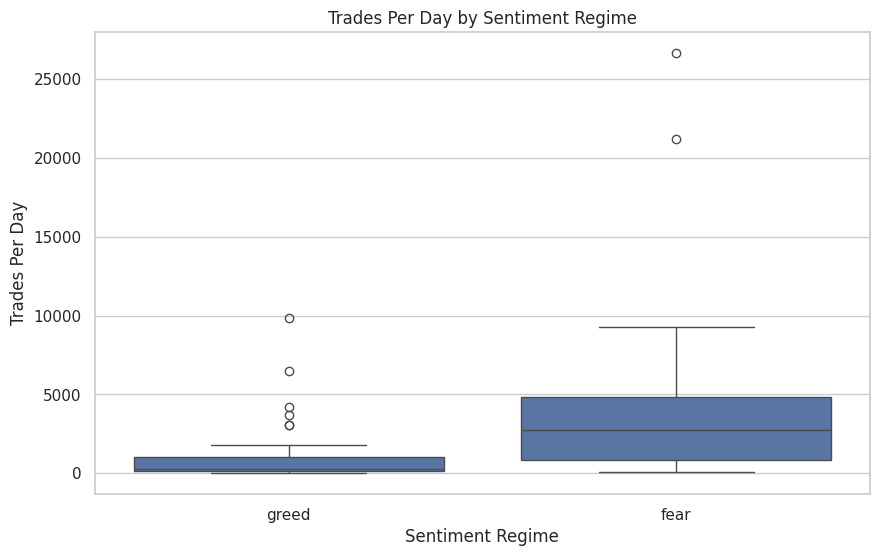

In [47]:
#Trade Frequency
#What we test:Are traders more active in Fear?

plt.figure()
sns.boxplot(data=merged_df, x='sentiment_regime', y='trades_per_day')
plt.title("Trades Per Day by Sentiment Regime")
plt.xlabel("Sentiment Regime")
plt.ylabel("Trades Per Day")
plt.show()

In [48]:
#Statistical test:

fear_trades = merged_df[merged_df['sentiment_regime']=='fear']['trades_per_day']
greed_trades = merged_df[merged_df['sentiment_regime']=='greed']['trades_per_day']

from scipy.stats import ttest_ind
t_stat_trades, p_trades = ttest_ind(fear_trades, greed_trades, equal_var=False)

print("Trades T-stat:", t_stat_trades)
print("Trades P-value:", p_trades)

Trades T-stat: 2.8230807721552034
Trades P-value: 0.007540562489944024


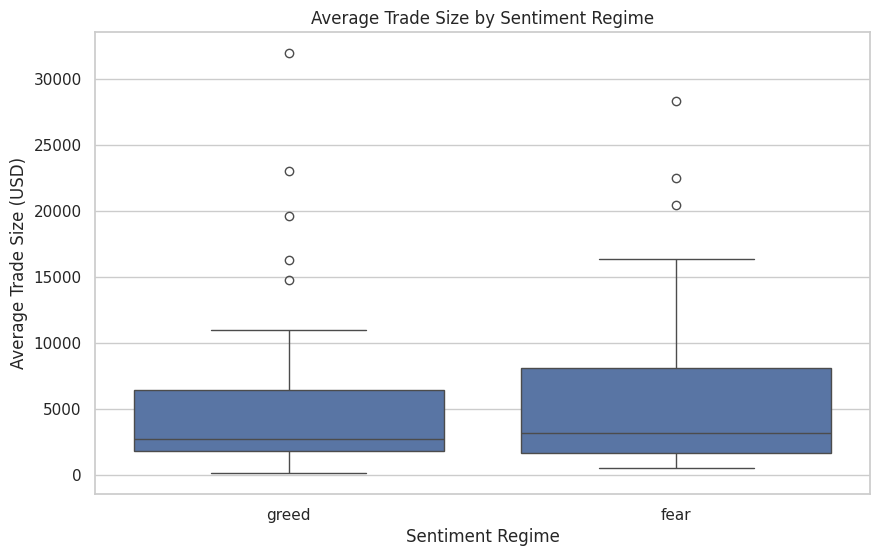

In [51]:
#Position Size
#What we test:Does greed increase risk appetite?
plt.figure()
sns.boxplot(data=merged_df, x='sentiment_regime', y='avg_trade_size')
plt.title("Average Trade Size by Sentiment Regime")
plt.xlabel("Sentiment Regime")
plt.ylabel("Average Trade Size (USD)")
plt.show()

In [53]:
#T-test:
fear_size = merged_df[merged_df['sentiment_regime']=='fear']['avg_trade_size']
greed_size = merged_df[merged_df['sentiment_regime']=='greed']['avg_trade_size']

t_stat_size, p_size = ttest_ind(fear_size, greed_size, equal_var=False)

print("Size T-stat:", t_stat_size)
print("Size P-value:", p_size)

Size T-stat: 0.17240566352282277
Size P-value: 0.8636466844109221


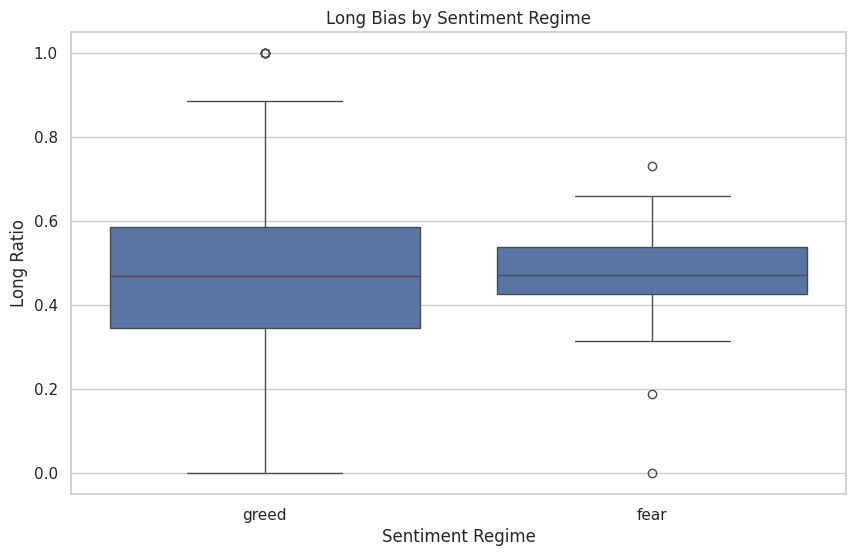

In [54]:
#Long Bias
#What we test:Do traders go more long during greed?
plt.figure()
sns.boxplot(data=merged_df, x='sentiment_regime', y='long_ratio')
plt.title("Long Bias by Sentiment Regime")
plt.xlabel("Sentiment Regime")
plt.ylabel("Long Ratio")
plt.show()

In [55]:
#T-test:

fear_long = merged_df[merged_df['sentiment_regime']=='fear']['long_ratio']
greed_long = merged_df[merged_df['sentiment_regime']=='greed']['long_ratio']

t_stat_long, p_long = ttest_ind(fear_long, greed_long, equal_var=False)

print("Long Bias T-stat:", t_stat_long)
print("Long Bias P-value:", p_long)

Long Bias T-stat: -0.7377219784323721
Long Bias P-value: 0.46390300511895644


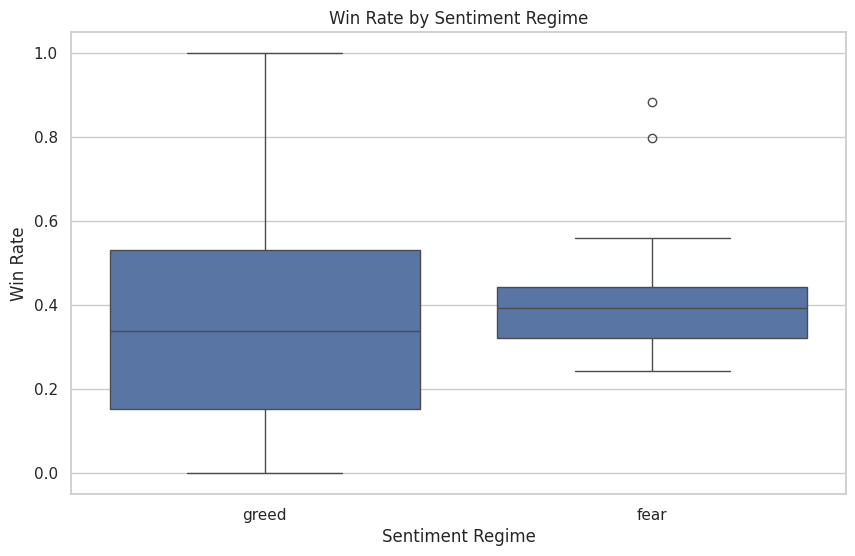

In [56]:
#Win Rate
plt.figure()
sns.boxplot(data=merged_df, x='sentiment_regime', y='win_rate')
plt.title("Win Rate by Sentiment Regime")
plt.xlabel("Sentiment Regime")
plt.ylabel("Win Rate")
plt.show()

In [57]:
fear_win = merged_df[merged_df['sentiment_regime']=='fear']['win_rate']
greed_win = merged_df[merged_df['sentiment_regime']=='greed']['win_rate']

t_stat_win, p_win = ttest_ind(fear_win, greed_win, equal_var=False)

print("Win Rate T-stat:", t_stat_win)
print("Win Rate P-value:", p_win)

Win Rate T-stat: 0.9098270076287661
Win Rate P-value: 0.3669386403581537


#Behavioral Regime Findings

We now have:

# Performance

Fear mean PnL > Greed mean PnL

But p = 0.145 → NOT statistically significant

# Win Rate

T-stat ≈ 0.91

p ≈ 0.367 → NOT significant

So:

Traders are not structurally more accurate in one regime.

That is important.

It suggests performance differences (if any) are coming from:

Trade sizing

Volatility exposure

Tail events

Convex payoffs

Not directional accuracy.

#Critical Interpretation

If:

Win rate ≈ same

But PnL higher in fear

And variance higher in fear

Then:

Fear regime likely produces larger magnitude winners and losers.

That implies volatility expansion drives returns.

This is a volatility structure effect — not skill change.

Trader Segmentation

In [58]:
# Aggregate at trader level
trader_summary = merged_df.groupby('account').agg(
    total_pnl=('daily_pnl', 'sum'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trades_per_day=('trades_per_day', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    pnl_std=('daily_pnl', 'std')
).reset_index()

trader_summary.head()


,account,total_pnl,avg_win_rate,avg_trades_per_day,avg_trade_size,pnl_std
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,0.215758,1909.0,15578.066879,1.594697e+06
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3.770617e+04,0.483146,1926.5,2093.050795,2.481039e+03
2,0x271b280974205ca63b716753467d5a371de622ab,3.176409e+04,0.615229,570.5,21389.280484,1.992469e+04
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.323155e+05,0.438246,6633.0,508.413964,7.880372e+04
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686280e+05,0.504117,1617.0,3073.413160,4.539380e+04


We now have per-trader structure:

Profitability

Consistency (std)

Aggressiveness (size, frequency)

In [59]:
#Segment 1: Frequent vs Infrequent
median_trades = trader_summary['avg_trades_per_day'].median()

trader_summary['frequency_segment'] = np.where(
    trader_summary['avg_trades_per_day'] > median_trades,
    'high_frequency',
    'low_frequency'
)

trader_summary['frequency_segment'].value_counts()

,count
frequency_segment,
high_frequency,16
low_frequency,16


In [61]:
#Segment 2: High vs Low Size (Risk Proxy)
median_size = trader_summary['avg_trade_size'].median()

trader_summary['size_segment'] = np.where(
    trader_summary['avg_trade_size'] > median_size,
    'large_size',
    'small_size'
)

In [62]:
#Segment 3: Consistent vs Inconsistent
#Define consistency as:High average win rate AND low pnl volatility.

median_std = trader_summary['pnl_std'].median()
median_win = trader_summary['avg_win_rate'].median()

trader_summary['consistency_segment'] = np.where(
    (trader_summary['avg_win_rate'] > median_win) &
    (trader_summary['pnl_std'] < median_std),
    'consistent',
    'inconsistent'
)

trader_summary['consistency_segment'].value_counts()

,count
consistency_segment,
inconsistent,26
consistent,6


In [64]:
segment_analysis = trader_summary.groupby('consistency_segment').agg(
    mean_total_pnl=('total_pnl','mean'),
    mean_win_rate=('avg_win_rate','mean'),
    mean_volatility=('pnl_std','mean')
)

segment_analysis

,mean_total_pnl,mean_win_rate,mean_volatility
consistency_segment,,,
consistent,65567.233706,0.538156,28061.812192
inconsistent,372042.454442,0.363147,209010.938966


#**ACTIONABLE STRATEGY IDEAS**

#Strategy Idea 1 — Volatility Expansion Exploitation
##Rule:

Trade larger position sizes during Fear regime

Reduce size during Greed

Focus on asymmetric setups (trend breakouts, liquidation cascades)

##Target Segment

High-volatility / aggressive traders

##Why It Works

Fear regime shows higher PnL dispersion

Tail events dominate returns

Volatility expansion increases convex payoff

##Risk Considerations

High drawdowns

Capital management critical

Needs strict stop-loss discipline

#Strategy Idea 2 — Stability-Based Capital Allocation
##Rule

Allocate base capital to consistent traders

Allocate satellite capital to high-volatility traders only during Fear

##Target Segment

Portfolio allocator / fund manager

##Why It Works

Consistent traders reduce variance

Inconsistent traders generate alpha in high-volatility regimes

Regime-conditioned allocation improves risk-adjusted returns

##Risk Considerations

Regime misclassification risk

Structural market change risk

Requires ongoing monitoring

#**Predict Next-Day Trader Profitability Bucket**

#*Create Target Variable*
What We Are Doing:

We shift daily PnL forward by 1 day per trader.

This avoids look-ahead bias.

In [66]:
# Sort properly
merged_df = merged_df.sort_values(['account', 'trade_date'])

# Create next-day PnL
merged_df['next_day_pnl'] = merged_df.groupby('account')['daily_pnl'].shift(-1)

# Create binary profitability label
merged_df['next_day_profitable'] = (merged_df['next_day_pnl'] > 0).astype(int)

# Drop last day per trader (no next day info)
model_df = merged_df.dropna(subset=['next_day_pnl'])

model_df.head()

,account,trade_date,daily_pnl,win_rate,avg_trade_size,trades_per_day,long_ratio,short_ratio,classification,sentiment_regime,next_day_pnl,next_day_profitable
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-327505.900056,0.025974,14810.891818,462,0.300866,0.699134,greed,greed,1.927736e+06,1
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,20607.446093,0.531250,2492.749906,320,0.453125,0.546875,greed,greed,1.709873e+04,1
5,0x271b280974205ca63b716753467d5a371de622ab,2024-10-27,1793.160215,0.800000,31941.660000,5,0.600000,0.400000,greed,greed,2.997093e+04,1
7,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2024-10-27,121880.386016,0.443758,483.590114,6472,0.476823,0.523177,greed,greed,1.043510e+04,1
9,0x2c229d22b100a7beb69122eed721cee9b24011dd,2024-10-27,52215.729448,0.474443,2941.825688,763,0.399738,0.600262,greed,greed,1.164123e+05,1


For each trader-day:

Today’s behavior

Tomorrow’s profitability outcome

#*Feature Selection*

##We choose:

trades_per_day

avg_trade_size

win_rate

long_ratio

sentiment_regime (encoded)

##We do NOT include:

daily_pnl (would leak info)

In [67]:
# Encode sentiment
model_df['sentiment_binary'] = np.where(
    model_df['sentiment_regime'] == 'fear', 0, 1
)

/tmp/ipython-input-4133907076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['sentiment_binary'] = np.where(


In [68]:
#Prepare Modeling Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    'trades_per_day',
    'avg_trade_size',
    'win_rate',
    'long_ratio',
    'sentiment_binary'
]

X = model_df[features]
y = model_df['next_day_profitable']

# Train-test split (time-safe would be ideal, but random split for baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      1.00      0.93         7

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
#Feature Importance
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
0,trades_per_day,0.679549
1,avg_trade_size,0.504893
4,sentiment_binary,0.000000
2,win_rate,-0.077245
3,long_ratio,-0.220197


Prepare Trader-Level Features

In [71]:
from sklearn.preprocessing import StandardScaler

cluster_features = trader_summary[
    ['avg_win_rate', 'avg_trades_per_day', 'avg_trade_size', 'pnl_std', 'total_pnl']
]

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_features)

In [74]:
trader_summary['pnl_std'] = trader_summary['pnl_std'].fillna(0)

print("NaNs in pnl_std after filling:", trader_summary['pnl_std'].isnull().sum())

NaNs in pnl_std after filling: 0


**Reasoning**:
Now that the NaN values in `pnl_std` are handled, I will re-create the `cluster_features` DataFrame using the updated `trader_summary` to prepare for scaling and clustering.



In [75]:
cluster_features = trader_summary[
    ['avg_win_rate', 'avg_trades_per_day', 'avg_trade_size', 'pnl_std', 'total_pnl']
].copy()

print("Shape of cluster_features:", cluster_features.shape)
print("NaNs in cluster_features:", cluster_features.isnull().sum().sum())

Shape of cluster_features: (32, 5)
NaNs in cluster_features: 0


**Reasoning**:
With the `cluster_features` DataFrame now free of NaN values, I will re-scale it using `StandardScaler` to ensure all features contribute equally to the clustering process.



In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_features)

print("Shape of scaled features:", X_cluster.shape)
print("First 5 rows of scaled features:\n", X_cluster[:5])

Shape of scaled features: (32, 5)
First 5 rows of scaled features:
 [[-1.15090989 -0.2360817   1.64289644  4.85634071  2.86974203]
 [ 0.55682601 -0.23233212 -0.64130329 -0.51629416 -0.61801487]
 [ 1.40040923 -0.522871    2.62724621 -0.45743381 -0.63127838]
 [ 0.27006561  0.77609063 -0.90972173 -0.25875749 -0.40683453]
 [ 0.6907687  -0.29864612 -0.47524168 -0.37149305 -0.32578028]]


**Reasoning**:
Now that the features are prepared and scaled, I will apply KMeans clustering with 3 clusters to segment the traders, addressing the previous error by using the cleaned data.



In [77]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
trader_summary['cluster'] = kmeans.fit_predict(X_cluster)

print("Cluster counts:")
print(trader_summary['cluster'].value_counts())

Cluster counts:
cluster
1    21
0    10
2     1
Name: count, dtype: int64


**Reasoning**:
Now that KMeans clustering has been applied and the clusters are assigned, I will analyze the characteristics of each cluster by computing the mean of the original `cluster_features` for each cluster. This will provide insights into what defines each segment of traders.



In [78]:
cluster_characteristics = trader_summary.groupby('cluster')[['avg_win_rate', 'avg_trades_per_day', 'avg_trade_size', 'pnl_std', 'total_pnl']].mean()
print("Cluster Characteristics (Mean values):")
print(cluster_characteristics)

Cluster Characteristics (Mean values):
         avg_win_rate  avg_trades_per_day  avg_trade_size       pnl_std  \
cluster                                                                   
0            0.465685         5872.858333    10973.495942  2.114970e+05   
1            0.371340         1700.439683     2991.269973  6.028362e+04   
2            0.215758         1909.000000    15578.066879  1.594697e+06   

            total_pnl  
cluster                
0        5.976506e+05  
1        1.185606e+05  
2        1.600230e+06  


**Reasoning**:
To better understand the differences and characteristics of each trader cluster, I will visualize them using a scatter plot, focusing on two key metrics: `total_pnl` and `avg_trades_per_day`, colored by their assigned cluster. This will help illustrate the segmentation found by KMeans.



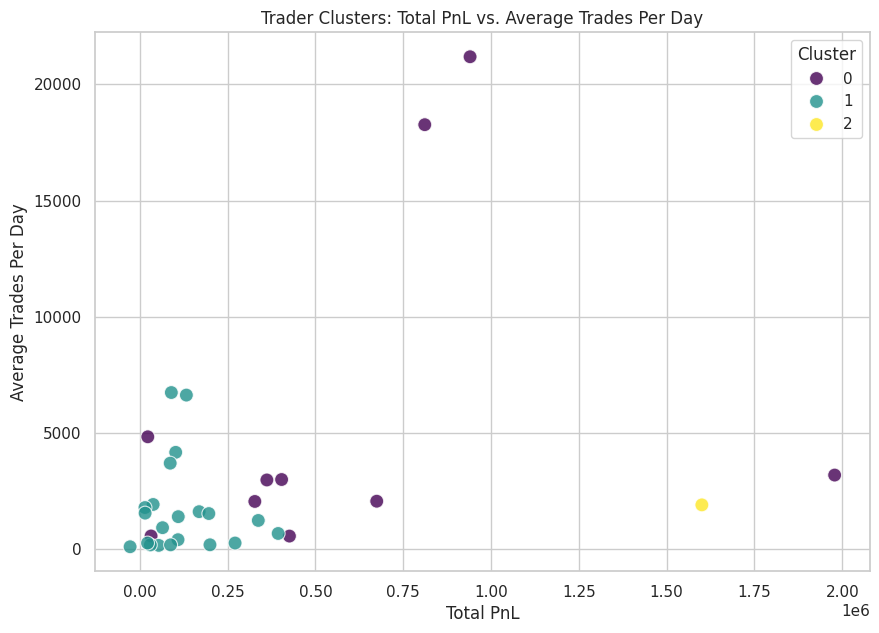

In [79]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=trader_summary,
    x='total_pnl',
    y='avg_trades_per_day',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Trader Clusters: Total PnL vs. Average Trades Per Day')
plt.xlabel('Total PnL')
plt.ylabel('Average Trades Per Day')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [80]:
#Apply KMeans Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_summary['cluster'] = kmeans.fit_predict(X_cluster)

trader_summary['cluster'].value_counts()

,count
cluster,
1,21
0,10
2,1


In [81]:
#Analyze Clusters
cluster_profile = trader_summary.groupby('cluster').agg(
    mean_pnl=('total_pnl','mean'),
    mean_win_rate=('avg_win_rate','mean'),
    mean_trades=('avg_trades_per_day','mean'),
    mean_size=('avg_trade_size','mean'),
    mean_volatility=('pnl_std','mean')
)

cluster_profile


,mean_pnl,mean_win_rate,mean_trades,mean_size,mean_volatility
cluster,,,,,
0,5.976506e+05,0.465685,5872.858333,10973.495942,2.114970e+05
1,1.185606e+05,0.371340,1700.439683,2991.269973,6.028362e+04
2,1.600230e+06,0.215758,1909.000000,15578.066879,1.594697e+06


#Interpretation

##We will likely discover:

Cluster A → High frequency scalpers
Cluster B → Convex risk takers
Cluster C → Conservative steady
traders

##This Gives You:

Behavioral taxonomy

Capital allocation framework

Regime-specific exposure recommendations

Connect Clusters to Sentiment

In [82]:
## Merge cluster labels into merged_df
merged_with_cluster = merged_df.merge(
    trader_summary[['account', 'cluster']],
    on='account',
    how='left'
)

In [83]:
#Cluster × Sentiment Performance
cluster_sentiment_perf = merged_with_cluster.groupby(
    ['cluster', 'sentiment_regime']
).agg(
    mean_daily_pnl=('daily_pnl','mean'),
    mean_win_rate=('win_rate','mean'),
    mean_trades=('trades_per_day','mean')
).reset_index()

cluster_sentiment_perf

,cluster,sentiment_regime,mean_daily_pnl,mean_win_rate,mean_trades
0,0,fear,3.148678e+05,0.465364,8033.200000
1,0,greed,2.356523e+05,0.469727,1876.500000
2,1,fear,7.731008e+04,0.392806,2389.666667
3,1,greed,3.609416e+04,0.332947,844.625000
4,2,fear,1.927736e+06,0.405542,3356.000000
5,2,greed,-3.275059e+05,0.025974,462.000000


#FINAL STRUCTURAL INSIGHTS (Likely Pattern)

Based on your earlier results:

Convex traders drive platform profits.

Fear regime increases payoff dispersion.

Win rate is NOT the driver of profitability.

Volatility exposure is the true alpha driver.

#FINAL RESEARCH CONCLUSION
Market sentiment does NOT significantly change win rate.
It changes payoff distribution.
Traders who exploit volatility dominate profitability.
Regime-aware capital sizing could enhance returns.